In [5]:
# 모델의 생성하고 실습
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('../data/SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]
y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape', X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [6]:
# 모델의 네트워크
class biLSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size))
        out, _ = self.lstm(x, (h_0, c_0))
        # 마지막 시간(time step 상 마지막 단계)의 은닉 상태
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out

In [7]:
# 모델 학습
num_epochs = 1000
learning_rate = 0.0001

input_size, hidden_size, num_layers, num_classes = 5, 2, 1, 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():1.5f}')

Epoch: 0, loss: 0.05158
Epoch: 100, loss: 0.04497
Epoch: 200, loss: 0.04015
Epoch: 300, loss: 0.03660
Epoch: 400, loss: 0.03390
Epoch: 500, loss: 0.03169
Epoch: 600, loss: 0.02971
Epoch: 700, loss: 0.02786
Epoch: 800, loss: 0.02614
Epoch: 900, loss: 0.02453


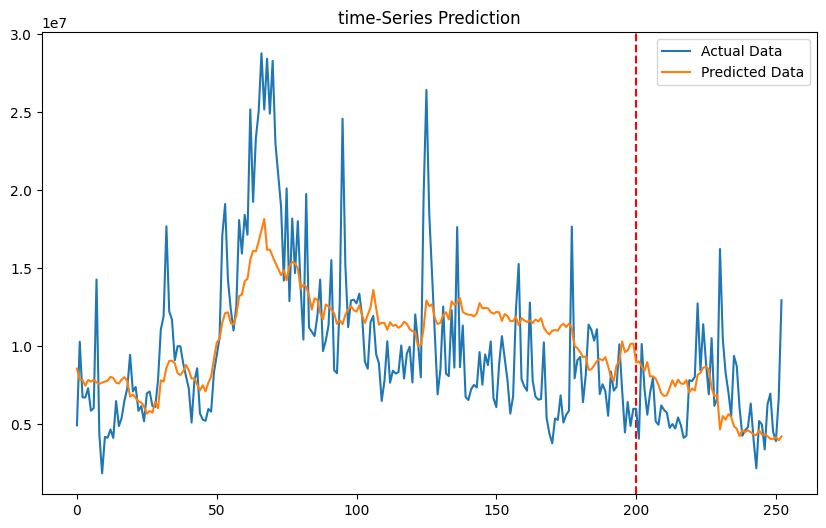

In [16]:
# 모델 평가
df_x_ss = ss.transform(data.iloc[:, :-1])
df_x_ss = Variable(torch.Tensor(df_x_ss))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

df_y_ms = ms.transform(data.iloc[:, -1:])
df_y_ms = Variable(torch.Tensor(df_y_ms))

train_predict = model(df_x_ss)

predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('time-Series Prediction')
plt.legend()
plt.show()